# Team Project

In [ ]:
# libraries to import
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpltlib
import seaborn as sns
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

sns.set(style="darkgrid")
%matplotlib inline

In [ ]:
## read datas

# region
tor_map = "Neighbourhoods.shp"
regions = gpd.read_file(tor_map)

# crime
crime_raw = pd.read_csv("Neighbourhood_Crime_Rates.csv")

# neighbourhood data
neighbourhood_raw = pd.read_csv("neighbourhood-profiles-2016-140-model.csv")


In [ ]:
%%capture --no-display
regions['neighbourhood'] = regions['FIELD_7'].str.replace(' \(.+\)', '')

# keep coordinates, polygons, and neighbourhood name
regions_cleaned = regions[['FIELD_11', 'FIELD_12', 'geometry', 'neighbourhood']]
regions_cleaned = regions_cleaned.rename(columns={'FIELD_11':'longitute', 'FIELD_12':'latitude'})


In [ ]:
# keep relevant variables for analysis. since the other csv contains data from 2016, only focus on 2016 data
crime_2016 = crime_raw[['Neighbourhood', 'Assault_2016', 'Assault_Rate2016', 'AutoTheft_2016', 'AutoTheft_Rate2016',
                      'BreakAndEnter_2016', 'BreakAndEnter_Rate2016', 'Robbery_2016', 'Robbery_Rate2016',
                      'TheftOver_2016', 'TheftOver_Rate2016', 'Homicide_2016', 'Homicide_Rate2016',
                      'Shootings_2016', 'Shootings_Rate2016']]

In [ ]:
# join crime data and heat map data
crime_regions = regions_cleaned.set_index('neighbourhood').join(crime_2016.set_index('Neighbourhood'))
crime_regions = crime_regions.reset_index()
crime_regions = crime_regions.fillna(0)

# create a total crimes
crime_regions['TotalCrimes_2016'] = crime_regions['Assault_2016']+ \
                            crime_regions['AutoTheft_2016']+ \
                            crime_regions['BreakAndEnter_2016']+ \
                            crime_regions['Robbery_2016']+ \
                            crime_regions['TheftOver_2016']+ \
                            crime_regions['Homicide_2016']+ \
                            crime_regions['Shootings_2016']
crime_regions['TotalCrimes_Rate2016'] = crime_regions['Assault_Rate2016']+ \
                            crime_regions['AutoTheft_Rate2016']+ \
                            crime_regions['BreakAndEnter_Rate2016']+ \
                            crime_regions['Robbery_Rate2016']+ \
                            crime_regions['TheftOver_Rate2016']+ \
                            crime_regions['Homicide_Rate2016']+ \
                            crime_regions['Shootings_Rate2016']


# create "property" type crimes variable
crime_regions['PropertyCrimes_2016'] = crime_regions['AutoTheft_2016'] + crime_regions['BreakAndEnter_2016'] + crime_regions['Robbery_2016'] + crime_regions['TheftOver_2016']
crime_regions['PropertyCrimes_Rate2016'] = crime_regions['AutoTheft_Rate2016'] + crime_regions['BreakAndEnter_Rate2016'] + crime_regions['Robbery_Rate2016'] + crime_regions['TheftOver_Rate2016']
# create "violence" type crimes variable
crime_regions['ViolenceCrimes_2016'] = crime_regions['Assault_Rate2016'] + crime_regions['Homicide_Rate2016']+ crime_regions['Shootings_Rate2016']
crime_regions['ViolenceCrimes_Rate2016'] = crime_regions['Assault_Rate2016'] + crime_regions['Homicide_Rate2016']+ crime_regions['Shootings_Rate2016']

In [ ]:
# Unpivot the neighbourhood dataframe
neighbourhood = pd.melt(neighbourhood_raw, id_vars=['Category','Topic','Data Source','Characteristic'])

In [ ]:
# cleaning neighbourhood
# remove rows that are not neighbourhood

# remove rows with variable = '_id'
neighbourhood = neighbourhood.drop(
    neighbourhood[neighbourhood["variable"] == '_id'].index
)

# remove rows with variable = 'City of Toronto'
neighbourhood = neighbourhood.drop(
    neighbourhood[neighbourhood["variable"] == 'City of Toronto'].index
)

# now in the neighbourhood we have only neighbourhood

In [ ]:
# adjust column names
neighbourhood = neighbourhood.rename(columns={'Category': 'category', 'Topic': 'topic', 'Data Source': 'data_source', 'Characteristic':'characteristic', 'variable': 'neighbourhood'})


In [ ]:
# function to return a dataframe filtering values from neighbourhood dataframme
def neighbourhoodDataframeValueFiltered(column, filter):
    newDataframe = neighbourhood[['characteristic','neighbourhood','value']].query('characteristic == "'+filter+'"')
    
    # adjust column name
    newDataframe = newDataframe.rename(columns={'value': column})

    # adjust type of column to int
    newDataframe[column] = newDataframe[column].str.replace(',', '')
    newDataframe = newDataframe.astype({column: float})
    newDataframe = newDataframe.drop('characteristic', axis=1)
    
    # return dataFrame 
    return newDataframe

In [ ]:
# dictionary with column name and condition to add from neighbourhood to crime_regions
dict_columns = {}
dict_columns['population'] = 'Population, 2016'
dict_columns['children'] = 'Children (0-14 years)'
dict_columns['youth']='Youth (15-24 years)'
dict_columns['workingAge']='Working Age (25-54 years)'
dict_columns['preRetirement']='Pre-retirement (55-64 years)'
dict_columns['seniors']='Seniors (65+ years)'
dict_columns['olderSeniors']='Older Seniors (85+ years)'
dict_columns['seniors_alone']='Persons age 65+ living alone (total)'
dict_columns['income']='Total income: Average amount ($)'
dict_columns['education']='Total - Highest certificate, diploma or degree for the population aged 15 years and over in private households - 25% sample data'
dict_columns['indigenous']='Total - Aboriginal identity for the population in private households - 25% sample data'
dict_columns['unemployment']='Employment rate'


In [ ]:
# loop to add columns (definied in dictionary) to crime_regions
for column in dict_columns:
    crime_regions = crime_regions.merge(neighbourhoodDataframeValueFiltered(column, dict_columns[column]), left_on='neighbourhood', right_on='neighbourhood')


In [ ]:
# convert variables to per capita measures (per 100000 people)
population_variables = ['children', 'youth', 'workingAge', 'preRetirement', 'seniors', 'olderSeniors', 'seniors_alone', 'education', 'indigenous']
# this should work but isn't generating the right numbers
# crime_regions[population_variables_colnames] = crime_regions.apply(lambda x: (x[population_variables]/x['population'] * 100000), axis=1)
for var in population_variables:
    crime_regions[var + '_percapita'] = crime_regions[var]/crime_regions['population']* 1000000

In [ ]:
crime_regions.head(10)

In [ ]:
predictors = [s + '_percapita' for s in population_variables] + ['population', 'income', 'unemployment']
# create correlation matrix to observe multicollinearity
matrix = crime_regions[predictors].corr(method = 'pearson', min_periods = 1)
sns.heatmap(matrix, annot = True)
plt.show()

In [ ]:
crime_regions.columns

In [ ]:
# PROPERTY CRIME RATE FEATURE SELECTION
# Rosa's stats stuff
lreg = LinearRegression()

# define predictors to be tested and dependent variable
x = crime_regions[predictors]
y = crime_regions['PropertyCrimes_Rate2016']

sfs1 = sfs(lreg, k_features=5, forward=False, verbose=1, scoring='neg_mean_squared_error')
sfsfit = sfs1.fit(x, y)
idx = sfsfit.k_feature_idx_
pd.DataFrame.from_dict(sfsfit.get_metric_dict()).T

In [ ]:
predictors_list = []
for x in idx:
    predictors_list.append(predictors[x])

x = crime_regions[predictors_list]
x = sm.add_constant(x)
    
model = sm.OLS(y, x).fit()
model.summary()

In [ ]:
# VIOLENT CRIME RATE FEATURE SELECTION
# david's stats stuff
lreg = LinearRegression()

# define predictors to be tested and dependent variable
x2 = crime_regions[predictors]
y2 = crime_regions['ViolenceCrimes_Rate2016']

sfs2 = sfs(lreg, k_features=5, forward=False, verbose=1, scoring='neg_mean_squared_error')
sfsfit2 = sfs2.fit(x2, y2)
idx2 = sfsfit2.k_feature_idx_
pd.DataFrame.from_dict(sfsfit2.get_metric_dict()).T

In [ ]:
predictors_list2 = []
for x in idx2:
    predictors_list2.append(predictors[x])

x2 = crime_regions[predictors_list2]
x2 = sm.add_constant(x2)
    
model2 = sm.OLS(y2, x2).fit()
model2.summary()

In [ ]:
# TOTAL CRIME RATE FEATURE SELECTION
lreg = LinearRegression()

# define predictors to be tested and dependent variable
x3 = crime_regions[predictors]
y3 = crime_regions['TotalCrimes_Rate2016']

sfs3 = sfs(lreg, k_features=5, forward=False, verbose=1, scoring='neg_mean_squared_error')
sfsfit3 = sfs3.fit(x3, y3)
idx3 = sfsfit3.k_feature_idx_
pd.DataFrame.from_dict(sfsfit3.get_metric_dict()).T

In [ ]:
predictors_list3 = []
for x in idx3:
    predictors_list3.append(predictors[x])

x3 = crime_regions[predictors_list3]
x3 = sm.add_constant(x3)
    
model3 = sm.OLS(y3, x3).fit()
model3.summary()

In [ ]:
%%capture --no-display
# Heat Map of Total Crime Rate by Neighbourhood in Toronto
fig, ax = plt.subplots(1, figsize=(40, 20))
ax.axis('off')
ax.set_title('Heat Map of Total Crime Rate (per 100,000) \nby Neighbourhood in Toronto, Ontario', fontdict={'fontsize': '40', 'fontweight' : '3'})

color = 'Oranges'
vmin, vmax = 0, crime_regions['TotalCrimes_Rate2016'].max()
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)

crime_regions.plot('TotalCrimes_Rate2016', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20))
for idx, row in crime_regions.iterrows():
    if(row['TotalCrimes_Rate2016'] > 2000):
        plt.annotate(text=row['neighbourhood'], xy=(row['longitute'], row['latitude']),
                 horizontalalignment='center', fontsize='large', color='black', wrap=True)
plt.show()

In [ ]:
%%capture --no-display
# Heat Map of Property Related Crimes by Neighbourhood in Toronto

fig, ax = plt.subplots(1, figsize=(40, 20))
ax.axis('off')
ax.set_title('Heat Map of Property Related Crimes by Neighbourhood in Toronto, Ontario', fontdict={'fontsize': '40', 'fontweight' : '3'})

color = 'Blues'
vmin, vmax = 0, crime_regions['PropertyCrimes_Rate2016'].max()
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)

crime_regions.plot('PropertyCrimes_Rate2016', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20))
for idx, row in crime_regions.iterrows():
    if(row['PropertyCrimes_Rate2016'] > 1000):
        plt.annotate(text=row['neighbourhood'], xy=(row['longitute'], row['latitude']),
                 horizontalalignment='center', fontsize='large', color='black', wrap=True)
plt.show()

In [ ]:
%%capture --no-display
# Heat Map of Violence Related Crimes by Neighbourhood in Toronto

fig, ax = plt.subplots(1, figsize=(40, 20))
ax.axis('off')
ax.set_title('Heat Map of Violent Crimes by Neighbourhood in Toronto, Ontario', fontdict={'fontsize': '40', 'fontweight' : '3'})

color = 'Greens'
vmin, vmax = 0, crime_regions['ViolenceCrimes_Rate2016'].max()
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)

crime_regions.plot('ViolenceCrimes_Rate2016', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20))
for idx, row in crime_regions.iterrows():
    if(row['ViolenceCrimes_Rate2016'] > 1000):
        plt.annotate(text=row['neighbourhood'], xy=(row['longitute'], row['latitude']),
                 horizontalalignment='center', fontsize='large', color='black', wrap=True)
plt.show()

In [ ]:
# assaults top 10 bar graph
crime_regions = crime_regions.sort_values(['TotalCrimes_Rate2016'], ascending=False)

fig, ax = plt.subplots()

ax.bar(crime_regions['neighbourhood'].iloc[:10], crime_regions['TotalCrimes_Rate2016'].iloc[:10])

ax.set_ylabel('Total Crime Rate \n(per 100,000 people)')
ax.set_title('Number of total crimes committed by neighbourhood (top 10)')

plt.show()

In [ ]:
plt.rc('figure', figsize=(12, 4))

x = np.arange(len(crime_regions['neighbourhood'].iloc[:5]))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()

#rects1 = ax.bar(x - width/2, men_means, width, label='Men')
assault = ax.bar(x - width/2, crime_regions['Assault_2016'].iloc[:5], width, label='Assault')
homicide = ax.bar(x + width/2, crime_regions['BreakAndEnter_2016'].iloc[:5], width, label='BreakAndEnter')
#rects2 = ax.bar(x + width/2, women_means, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Crimes')
ax.set_title('Assault/Break and Enter by neighbourhood')
ax.set_xticks(x, crime_regions['neighbourhood'].iloc[:5])
ax.legend()

ax.bar_label(assault, padding=3)
ax.bar_label(homicide, padding=3)

fig.tight_layout()

plt.show()

In [ ]:
crime_regions = crime_regions.sort_values(['TotalCrimes_2016'], ascending=False)

plt.plot(crime_regions['neighbourhood'].iloc[:5],crime_regions['Assault_2016'].iloc[:5])
plt.plot(crime_regions['neighbourhood'].iloc[:5],crime_regions['AutoTheft_2016'].iloc[:5])
plt.plot(crime_regions['neighbourhood'].iloc[:5],crime_regions['BreakAndEnter_2016'].iloc[:5])
plt.plot(crime_regions['neighbourhood'].iloc[:5],crime_regions['Robbery_2016'].iloc[:5])
plt.plot(crime_regions['neighbourhood'].iloc[:5],crime_regions['TheftOver_2016'].iloc[:5])
plt.plot(crime_regions['neighbourhood'].iloc[:5],crime_regions['Homicide_2016'].iloc[:5])
plt.plot(crime_regions['neighbourhood'].iloc[:5],crime_regions['Shootings_2016'].iloc[:5])


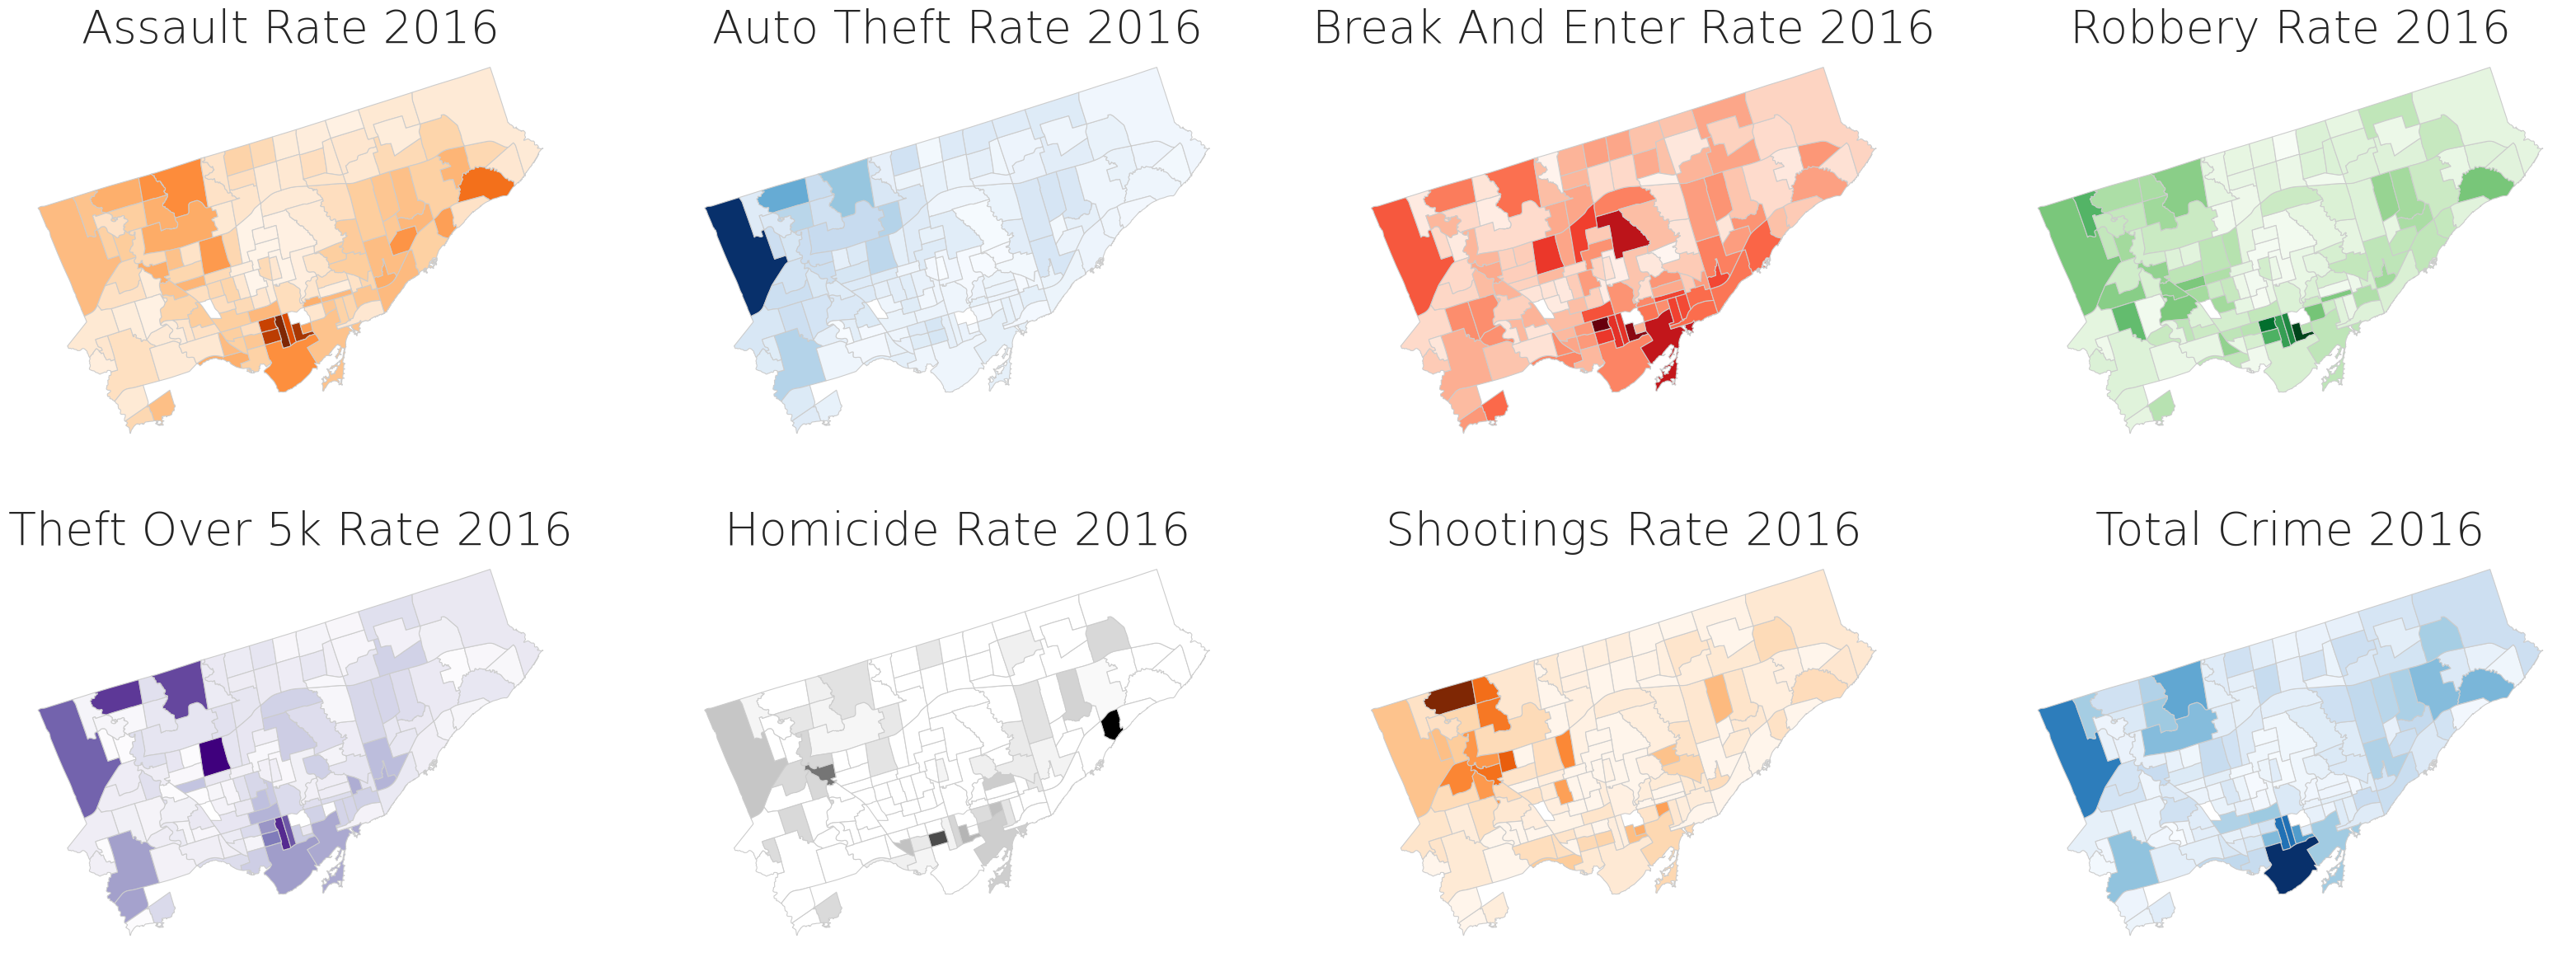

In [100]:
%%capture --no-display
# make smaller plots so we can visually compare them
crimes_of_interest_column_names = ["Assault_Rate2016", "AutoTheft_Rate2016", "BreakAndEnter_Rate2016", 
                                   "Robbery_Rate2016", "TheftOver_Rate2016", "Homicide_Rate2016", "Shootings_Rate2016", "TotalCrimes_2016"]
# ensure this matches with the column names
crimes_of_interest_plot_titles = ["Assault Rate 2016", "Auto Theft Rate 2016", "Break And Enter Rate 2016", 
                                  "Robbery Rate 2016", "Theft Over 5k Rate 2016", "Homicide Rate 2016", "Shootings Rate 2016", "Total Crime 2016"]
#colors = plt.cm.Sequential
colors = ["Oranges", "Blues", "Reds", "Greens", "Purples", "Greys"]

fig_width = 10
fig_height = fig_width * 1.45

# make the plots
#fig, axs = plt.subplots(ncols=len(crimes_of_interest_column_names), figsize=(fig_width * len(crimes_of_interest_column_names), fig_height))
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(fig_width * 4, fig_height))

for i in range(0, 2):
    for j in range(0,4):
        index = i * 4 + j        
        if (index > len(crimes_of_interest_column_names)):
            break
            
        axs[i, j].axis("off")
        
        crime_column = crimes_of_interest_column_names[index]
        crime_name = crimes_of_interest_plot_titles[index]
                  
        axs[i, j].set_title(f"{crime_name}", fontdict={'fontsize': '40', 'fontweight' : '5'})

        color = colors[index % len(colors)]
        vmin, vmax = 0, crime_regions[crime_column].max()
        scalar_mappable = mpltlib.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=color)

        #cbar = fig.colorbar(scalar_mappable)
        #cbar.ax.tick_params(labelsize=14)

        crime_regions.plot(crime_column, cmap=color, linewidth=0.8, ax=axs[i, j], edgecolor='0.8', figsize=(fig_width, fig_height))

    
plt.show()
    


In [ ]:
#####################
discard = '''
# make the plot
fig, ax = plt.subplots(1, figsize=(10,5))
ax.axis('off')
ax.set_title('Heat Map of Unemployment', fontdict={'fontsize': '10', 'fontweight' : '3'})

color = 'Blues'
vmin, vmax = 0, 231
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)

merged.plot('Assault_2016', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(10,5))

plt.show()
'''

In [ ]:
%%capture --no-display
# make smaller plots so we can visually compare them
crimes_of_interest_column_names = ["Assault_2016", "AutoTheft_2016", "BreakAndEnter_2016", "Robbery_2016", "TheftOver_2016", "Homicide_2016", "Shootings_2016"]
#colors = plt.cm.Sequential
colors = ["Oranges", "Blues", "Reds", "Greens"]

fig_width = 5
fig_height = 5

# make the plots
fig, axs = plt.subplots(ncols=len(crimes_of_interest_column_names), figsize=(fig_width * len(crimes_of_interest_column_names), fig_height))
# common settings for all plots:
for ax in axs:
    ax.axis('off')

# unique settings:
for i in range(0, len(crimes_of_interest_column_names)):
    crime_column = crimes_of_interest_column_names[i]
    #todo: fix title crime name
    axs[i].set_title(f"{crime_column}", fontdict={'fontsize': '10', 'fontweight' : '3'})

    color = colors[i % len(colors)]
    vmin, vmax = 0, crime_regions[crime_column].max()
    scalar_mappable = mpltlib.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=color)
    
    #cbar = fig.colorbar(scalar_mappable)
    #cbar.ax.tick_params(labelsize=14)

    crime_regions.plot(crime_column, cmap=color, linewidth=0.8, ax=axs[i], edgecolor='0.8', figsize=(fig_width, fig_height))

    
plt.show()
    

In [ ]:
# Unpivot the crime dataframe
crime_years = pd.melt(crime_raw, id_vars=['OBJECTID','Neighbourhood','Hood_ID','F2020_Population_Projection','Shape__Area','Shape__Length'])


In [ ]:
# adjust the variable column to split
crime_years['variable'] = crime_years['variable'].str.replace('_Rate', 'Rate_')


In [ ]:
# split variable column into crime_type and year
crime_years[['crime_type','year']] = crime_years['variable'].str.split('_', expand=True)


In [ ]:
# remove columns that are not used
crime_years = crime_years.drop('OBJECTID', axis=1)
crime_years = crime_years.drop('Hood_ID', axis=1)
crime_years = crime_years.drop('F2020_Population_Projection', axis=1)
crime_years = crime_years.drop('Shape__Area', axis=1)
crime_years = crime_years.drop('Shape__Length', axis=1)
crime_years = crime_years.drop('variable', axis=1)


In [ ]:
crime_years